In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import cv2

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"muahammadrionandod","key":"d0c9f1dfec82f6af90fcc9cc62f00bc5"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

covid-face-mask-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!mkdir dataset
!unzip -qq covid-face-mask-detection-dataset.zip -d dataset
!ls dataset

mkdir: cannot create directory ‘dataset’: File exists
replace dataset/New Masks Dataset/Test/Mask/2070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/New Masks Dataset/Test/Mask/2072.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/New Masks Dataset/Test/Mask/2083.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
'New Masks Dataset'


In [7]:
Data_folder = '/content/dataset/New Masks Dataset'
train_f = os.path.join('/content/dataset/New Masks Dataset/Train')
test_f = os.path.join('/content/dataset/New Masks Dataset/Test')
valid_f = os.path.join('/content/dataset/New Masks Dataset/Validation')
mask_train = os.path.join(train_f,'Mask')
nomask_train = os.path.join(train_f,'Non Mask')

In [8]:
mask_train_name = os.listdir(mask_train)
print(mask_train_name[:25])
nomask_train_name = os.listdir(nomask_train)
print(nomask_train_name[:25])

['0110.jpg', '1553.jpg', '1136.jpg', '0116.png', '0583.jpg', '0972.jpg', '1290.jpg', '0561.jpg', '1155.jpg', '0160.jpg', '0029.jpg', '1107.jpg', '1513.jpg', '1159.jpg', '0901.jpeg', '1133.jpg', '1490.jpg', '0838.jpg', '1628.jpg', '0988.jpg', '1455.jpg', '0784.jpg', '0153.jpg', '1462.jpg', '0787.jpg']
['309.jpg', '221.jpg', '187.jpg', '49.jpg', '138.jpg', '46.jpg', '259.jpg', '170.jpg', '194.jpg', '220.jpg', '89.jpg', '250.jpg', '133.jpg', '287.jpg', '9.jpg', '87.jpg', '155.jpg', '120.jpg', '263.jpg', '341.jpg', '233.jpg', '248.jpg', '247.jpg', '246.jpg', '118.jpg']


['/content/dataset/New Masks Dataset/Train/Mask/1553.jpg', '/content/dataset/New Masks Dataset/Train/Mask/1136.jpg', '/content/dataset/New Masks Dataset/Train/Mask/0116.png', '/content/dataset/New Masks Dataset/Train/Mask/0583.jpg', '/content/dataset/New Masks Dataset/Train/Mask/0972.jpg', '/content/dataset/New Masks Dataset/Train/Mask/1290.jpg', '/content/dataset/New Masks Dataset/Train/Mask/0561.jpg', '/content/dataset/New Masks Dataset/Train/Mask/1155.jpg', '/content/dataset/New Masks Dataset/Train/Mask/0160.jpg']
['/content/dataset/New Masks Dataset/Train/Non Mask/221.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/187.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/49.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/138.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/46.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/259.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/170.jpg', '/content/dataset/New Masks Dataset/Train/Non Mask/

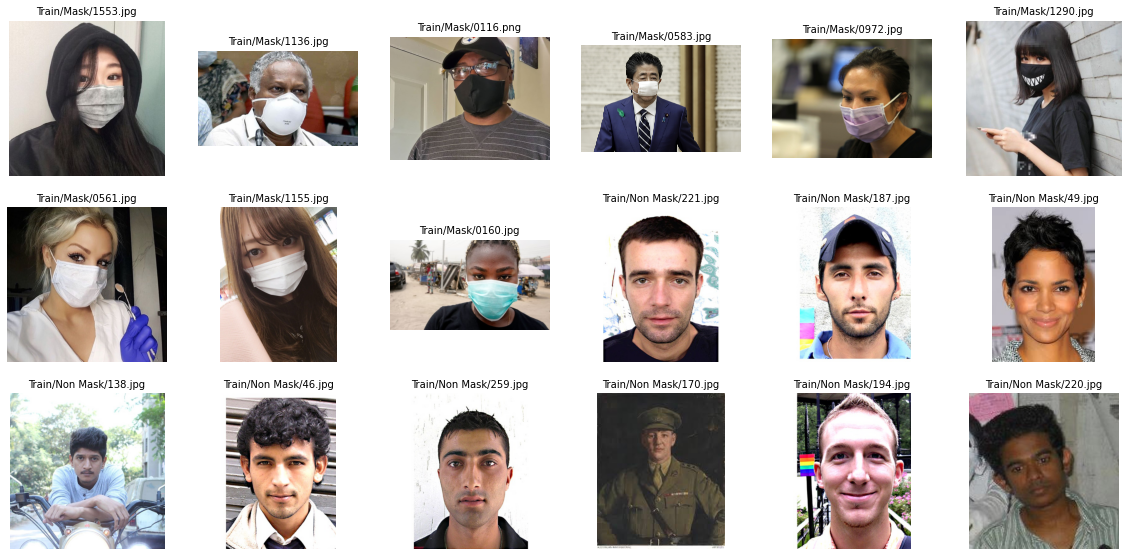

In [9]:
rows = 6
cols = 6
plt.figure(figsize=(20,20))

with_mask = []
for i in mask_train_name[1:10]:
  with_mask.append(os.path.join(mask_train,i))

without_mask = []
for i in nomask_train_name[1:10]:
  without_mask.append(os.path.join(nomask_train,i))

print(with_mask)
print(without_mask)

merged = with_mask+without_mask

for i in range(0,len(merged)):
  data = merged[i].split('/',4)[4]
  sp = plt.subplot(6,6,i+1)
  sp.axis('Off')
  image = mpimg.imread(merged[i])
  sp.set_title(data,fontsize=10)
  plt.imshow(image,cmap='gray')

plt.show()
  


# Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.3,
                                   rotation_range = 35,
                                   horizontal_flip = True
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_f,
                                                    target_size=(150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary'
                                                    )
test_generator = test_datagen.flow_from_directory(test_f,
                                                    target_size=(150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary'
                                                    )
valid_generator = validation_datagen.flow_from_directory(valid_f,
                                                    target_size=(150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary'
                                                    )

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'Mask': 0, 'Non Mask': 1}

In [12]:
train_generator.image_shape

(150, 150, 3)

# Building CNN Model

In [13]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='SAME',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))



model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()



#model.add(Conv2D(128,(3,3),padding='SAME',activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

#model.add(Conv2D(256,(3,3),padding='SAME',activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

In [14]:
model.compile(Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit(train_generator,epochs = 20,validation_data = valid_generator)

Epoch 1/20
19/19 [==============================] - 40s 2s/step - loss: 1.6950 - accuracy: 0.5433 - val_loss: 0.6788 - val_accuracy: 0.5131
Epoch 2/20
19/19 [==============================] - 39s 2s/step - loss: 0.5829 - accuracy: 0.6917 - val_loss: 0.4893 - val_accuracy: 0.8660
Epoch 3/20
19/19 [==============================] - 37s 2s/step - loss: 0.3778 - accuracy: 0.8633 - val_loss: 0.3876 - val_accuracy: 0.8824
Epoch 4/20
19/19 [==============================] - 37s 2s/step - loss: 0.3424 - accuracy: 0.8550 - val_loss: 0.3319 - val_accuracy: 0.9020
Epoch 5/20
19/19 [==============================] - 37s 2s/step - loss: 0.2811 - accuracy: 0.9183 - val_loss: 0.3147 - val_accuracy: 0.9020
Epoch 6/20
19/19 [==============================] - 37s 2s/step - loss: 0.2248 - accuracy: 0.9200 - val_loss: 0.3220 - val_accuracy: 0.8791
Epoch 7/20
19/19 [==============================] - 37s 2s/step - loss: 0.2973 - accuracy: 0.8817 - val_loss: 0.3352 - val_accuracy: 0.8954
Epoch 8/20
19/19 [==

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

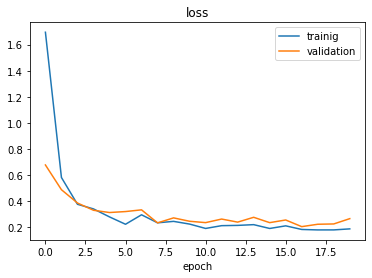

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['trainig','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

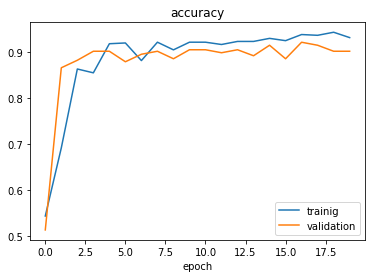

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['trainig','validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [19]:
test_loss , test_acc = model.evaluate(test_generator)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 2s 474ms/step - loss: 0.2383 - accuracy: 0.8900
test acc :0.8899999856948853 test loss:0.2383078634738922


In [20]:
model.save('1.model.model')

INFO:tensorflow:Assets written to: 1.model.model/assets
